In [ ]:
# !pip install torch==1.4.0 torchvision==0.4.1

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import pickle as pkl
import math
from tqdm import tqdm
import copy
import time
import random

In [2]:
print(torch.__version__ )

1.8.1+cu101


In [3]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [4]:
def walk(path):
  if not os.path.exists(path):
    return -1
    for root, dirs, names in os.walk(path):
      for filename in names:
        print(os.path.join(root,filename))

In [6]:
def findNearestSmallerTime(refTime, location_msg):
  left = 0
  right = len(location_msg) - 1
  Time = location_msg["Time"]
  while left < right - 1: 
    mid = (int)(left + (right - left)/2)
    if Time.loc[mid] == refTime :
      return location_msg.loc[mid]
    elif Time.loc[mid] < refTime:
      left = mid
    else:
      right = mid - 1;
  if Time.loc[right]  < refTime:
    return location_msg.loc[right]
  else:
    return location_msg.loc[left]

In [7]:
def concatData(ctrl_msg, loc_msg):
  df = pd.DataFrame(columns=['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'])
  for idx, data in ctrl_msg.iterrows():
    # print(data['Time'])
    loc_msg_pair = findNearestSmallerTime(data['Time'], loc_msg)
    df.loc[idx] = [data['Time'], data['Acc_TarA'], data['EPSDAIReq'], loc_msg_pair['easting'], loc_msg_pair['northing'], loc_msg_pair['speed'], loc_msg_pair['yaw'], loc_msg_pair['Time']]
    # print(df.loc[idx])
  return df

In [8]:
def processData(project_path, data_path):
  data_files = np.sort(next(os.walk(data_path))[1])
  data_root = next(os.walk(data_path))[0]
  # print(os.path.join(data_root, data_files[0]))
  # print(data_root)
  # len(data_files)
  for idx in range (len(data_files)) :
    cur_path = os.path.join(data_root, data_files[idx])
    loc_msg = pd.read_csv(cur_path + "/location_msg.csv")
    vehctrl_msg = pd.read_csv(cur_path + "/vehctrl_msg.csv")
    vehctrl_msg_auto = vehctrl_msg[vehctrl_msg["Acc_Mode"] == 3]
    vehctrl_msg_auto = vehctrl_msg_auto[vehctrl_msg_auto["EPSReqTyp"] == 4]
    curData = concatData(vehctrl_msg_auto, loc_msg)
    curData.to_csv(project_path + "/processed_data/" + str(idx + 1) + '.csv')
  print("Finished")

DATA PREPROCESS IS OVER

In [10]:
def getConsecutive(processed_data, window_length = 22, stride = 2, num_features = 4):
  break_idx = []
  for i in range(len(processed_data)):
    if i >= 1:
      if processed_data['Req_Time'].loc[i] - processed_data['Req_Time'].loc[i - 1] > 0.07:
        break_idx.append(i)
  # break_idx[i] to break_idx[i + 1] - 1
  # print(break_idx)
  if len(break_idx) == 0:
    x = getWindow(processed_data, window_length, stride, num_features)  
  elif len(break_idx) == 1:
    x1 = getWindow(processed_data.loc[:break_idx[0] - 1], window_length, stride, num_features)
    x2 = getWindow(processed_data.loc[break_idx[0]:], window_length, stride, num_features)
    if x1 is not None and x2 is not None:
      x = np.concatenate((x1,x2), axis = 1)
    elif x1 is not None :
      x = x1
    elif x2 is not None:
      x = x2
    else:
      x = None
  else:
    x_start = getWindow(processed_data.loc[ : break_idx[0] - 1], window_length, stride, num_features)
    for j in range(0 , len(break_idx) - 1):
      x_next = getWindow(processed_data.loc[break_idx[j] : (break_idx[j + 1] - 1)], window_length, stride, num_features)
      if x_start is not None and x_next is not None:
        x_start = np.concatenate((x_start, x_next), axis = 1)
      elif x_next is not None:
        x_start = x_next
      elif x_start is not None:
        x_start = x_start

    x_end = getWindow(processed_data.loc[break_idx[len(break_idx) - 1]:], window_length, stride, num_features)
    # print(x_start.shape)
    # print(x_end.shape)
    if x_start is not None and x_end is not None:
      x = np.concatenate((x_start, x_end), axis = 1)
    elif x_start is not None:
      x = x_start
    elif x_end is not None:
      x = x_end   
  print("Add  " + str(x.shape) + "  data")
  return x

In [11]:
'''
Acc_TarA ,
EPS_DAI ,
'speed', 
'yaw',
dT,
['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
return X: dim = 3 [window_length = 20, numSamples[clip here], feature_number = 4] ,
'''
def getWindow(processed_data, window_length, stride, num_features = 7):
  length = len(processed_data)
  window_length = window_length + 1
  num_samples = (length - window_length)//stride + 1
  if num_samples <= 0:
    return None
  X = np.zeros([window_length, num_samples, num_features])
  for sample_idx in np.arange(num_samples):
    start_x = stride*sample_idx
    end_x = start_x + window_length
    X[ :, sample_idx, :] = processed_data.iloc[start_x : end_x, 2:]
  return X

# Get data on the fly


Encoder Decoder Network

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size: int = 4,
                 embedding_size: int =32 ,
                 hidden_size: int = 64):
        """Initialize the encoder network.

        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM

        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)
                                 
    def forward(self, x: torch.FloatTensor, hidden) :

        embedded = F.relu(self.linear1(x))
        embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        return hidden

In [15]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=32, hidden_size=64, input_size=4, output_size=2):
        """Initialize the decoder network.

        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output

        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, embedding_size)
        self.linear3 = nn.Linear(embedding_size, 1)
        self.linear4 = nn.Linear(embedding_size, 1)
        # self.linear3 = nn.Linear(embedding_size, output_size)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)

    def forward(self, x, hidden):
        """Run forward propagation.

        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state

        """
        embedded = F.relu(self.linear1(x))
        # embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        output = F.relu(self.linear2(hidden[0]))
        acc = self.linear3(output)
        yaw_rate = self.linear4(output)
        # print("out_shape")
        # print(output.shape)
        return torch.cat((acc,yaw_rate), 1), hidden

In [55]:
'''
['Acc_TarA', 'EPSDAIReq'  'acc', 'speed', 'dT', 'acc', 'yaw_rate']
'''
class ModelDataset(Dataset):
  def __init__(self, data, transforms, input_seqlen, rollout_seqlen):
    self.transform = transforms
    self.data = data
    self.input_seqlen = input_seqlen
    self.acc_max = max_abs_acc
    self.yawrate_max = max_abs_yaw_rate


  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'acc', 'speed'

    model_input = self.data[ :, :4, index]
    target = self.data[ -1, 5:7, index]
    # helper : 
    
    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)


    return model_input, target

  def __len__(self):
    return self.data.shape[2]

In [56]:
class ModelUtils():
  def __init__(self, save_dir, batch_size, hidden_size, gpu_bool):
    self.save_dir = save_dir
    self.batch_size = batch_size
    self.hidden_size = hidden_size

  def init_weight(self, lstm):
    for name, param in lstm.named_parameters():
      if 'bias' in name:
        nn.init.constant(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_normal(param)
  
  def init_zero_state(self):
    """Get initial hidden state for LSTM.

        Args:
            batch_size: Batch size
            hidden_size: Hidden size of LSTM

        Returns:
            Initial hidden states

    """
    
    if gpu_bool:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    return (
        torch.zeros( self.batch_size, self.hidden_size).to(device),
        torch.zeros( self.batch_size, self.hidden_size).to(device),
    )
  def save_model(self, model, save_dir, name):
    torch.save(model, save_dir + name + '.pkl')

  def load_model(self, save_dir, name):
    loaded_model = torch.load(save_dir + name + '.pkl')
    return loaded_model
  

In [ ]:
max(np.abs([-5,6,-10]))

10

In [68]:
def getInput(data_temp, window_size, constant_):
  input = None
  '''
  ['Acc_TarA', 'EPSDAIReq'  'acc', 'speed', 'dT', 'acc', 'yaw_rate']
  '''

  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 7), dtype=float)
      # 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]
      speed = data_temp[ : window_size, index, 4]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = speed
      cur_input[:, 4] = dT
      cur_input[:, 5] = acc_real
      cur_input[:, 6] = yaw_rate*constant_
      


      if input is None:
        input = cur_input
      else:
        input = np.dstack((input, cur_input))
      
  return input

In [58]:
def train(train_dataloader, 
          validation_dataloader,
          batch_size,
          epochs,
          criterion,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          encoder_scheduler,
          decoder_scheduler,
          model_utils: ModelUtils,
          inputseq_len: int = 20,
          rollout_len: int = 1,
          gpu_bool = True,
  ) -> None:

  if gpu_bool:
    encoder.cuda()
    decoder.cuda()


  # model_utils.init_weight(decoder)
  encoder_hidden = model_utils.init_zero_state()

  global_step = 0
  print("Start Training...")

  training_loss_store = []
  validation_loss_store = []

  '''['Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw']
  '''
  '''data ： 
  
  '''
  try:
    with tqdm(range(epochs)) as t:
      for epoch in t:
        ########################### Training #####################################
        loss = 0.0
        print("\n")
        print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")

        loss_sum = 0.0
        count = 0

        encoder.train()
        decoder.train()
        # prev state: real velocity, real yaw_dot, real speed
        # data[0]  'Acc_TarA', 'EPSDAIReq' 'a at t - 1' 'yaw_rate at t - 1'
        # data[1]  'acc_real' 'yaw_rate_real'
        # data[2]  dT

       
        
        for batch_index, data in enumerate(train_dataloader):

          encoder.train()
          decoder.train()
          # Zero the gradients
          encoder_optimizer.zero_grad()
          decoder_optimizer.zero_grad()

          encoder_hidden = model_utils.init_zero_state()

          model_input = data[0].float()
          target = data[1].float()

          # print(model_input.shape)
          # print(target.shape)

          if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")
          
          model_input = model_input.to(device)
          target = target.to(device)
          
          for ei in range(inputseq_len):
            # if gpu_bool:
            #   encoder_hidden = (encoder_hidden[0].cuda(), encoder_hidden[1].cuda())
            encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)
          
          # Initialize decoder hidden state as encoder hidden state
          decoder_hidden = encoder_hidden

          
          # print(encoder_hidden[0].shape)
          # print(encoder_hidden[1].shape)
          
          # Decode hidden state in future trajectory
          # decoder output is (given the prev state)
          
          decoder_input = model_input[:, inputseq_len - 1, :]
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)  


          loss = criterion(decoder_output[:,:2], target)
          
          # Backpropagate
          loss.backward(retain_graph=True)

          loss_val = loss.cpu().data.numpy().item()


          torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
          torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)

          encoder_optimizer.step()
          decoder_optimizer.step()

          

          if global_step % 20 == 0 and loss < 10:

            val_loss, abnormal_cnt = validate( validation_dataloader, epoch, 
            criterion, 
            encoder, 
            decoder, 
            model_utils, 
            input_seqlen,
            rollout_len,
            gpu_bool)

            print(f"Train -- Epoch: {epoch}, loss: {loss}, Rollout: {rollout_len}")
            validation_loss_store.append(val_loss)
            training_loss_store.append(loss_val)

          global_step += 1

        print('--- abnormal batch count is : ' + str(abnormal_cnt))

        encoder_scheduler.step()
        decoder_scheduler.step()      
            
  except KeyboardInterrupt:
    t.close()
    raise
  t.close()
  return training_loss_store, validation_loss_store


# Extract data from original csv

In [59]:
def validate(
    val_loader,
    epoch: int,
    criterion,
    encoder,
    decoder,
    model_utils: ModelUtils,
    input_seqlen,
    rollout_len,
    gpu_bool):

   
   total_loss = 0.0 
   count = 1
   abnormal_count = 0

   with torch.no_grad(): 
      for batch_index, data in enumerate(val_loader):

          model_input = data[0].float()
          target = data[1].float()

          # Set to eval mode
          encoder.eval()
          decoder.eval()

          if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")
          
          model_input = model_input.to(device)
          target = target.to(device)

          # Initialize encoder hidden state
          encoder_hidden = model_utils.init_zero_state()

          # Initialize loss
          loss = 0.0

          for ei in range(input_seqlen):
                # if gpu_bool:
                #   encoder_hidden = (encoder_hidden[0].cuda(), encoder_hidden[1].cuda())
                encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)

          # Initialize decoder hidden state as encoder hidden state
          decoder_hidden = encoder_hidden

          decoder_input = model_input[:, input_seqlen - 1, :]
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)  

          loss = criterion(decoder_output[:,:2], target)

          if loss > 10:
            abnormal_count = abnormal_count + 1
          else :
            count = count + 1
            total_loss += loss.item()

          # print(f"Train -- Epoch: {epoch}, loss: {loss}")

   avg_loss = total_loss/count

   print(f"Train -- Epoch: {epoch}, validation loss: {avg_loss}")

   return avg_loss, abnormal_count

 Model input :# 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
                             
 state :  'easting', 'northing', 'speed', 'yaw', 'dT'


In [30]:
def visualize_result_state(pred_state, real_state, name):
  x = np.linspace( 0, 1, len(pred_state))
  plt.plot(x, pred_state,'-', c='r', label = "Preddicted " + name) #input sequence
  plt.plot(x ,real_state,'-',c='g', label = "Ground truth " + name) #ground truth

  plt.xlabel('Time Step ')
  plt.ylabel( name )
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

def visualize_result_position(pred_x, pred_y, real_x, real_y):
  ax = plt.gca()
  plt.plot(pred_x[0],pred_y[0],'-o',c='b') #starting point here
  plt.plot(pred_x, pred_y,'-',c='r',label = "Predicted Trajectory")
  plt.plot(real_x, real_y,'-',c='g',label = "Ground Truth Trajectory")

  plt.xlabel('map_x_coord (m)')
  plt.ylabel('map_y_coord (m)')
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

In [77]:
'''
['Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time']
'''
class TestDataset(Dataset):
  def __init__(self, model_input, cumulated_state, transforms=None, input_seqlen = 20, rollout_seqlen = 1):
    self.transform = transforms

    self.model_input = model_input
    self.cumulated_state = cumulated_state

    self.input_seqlen = input_seqlen

  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'acc', 'velocity',  
    model_input = self.model_input[ :input_seqlen , :4, index]
    target = self.model_input[ : , 4:6, index]
    command = self.model_input[:, :2, index]
    cumulated_state = self.cumulated_state[ :, :, index]
    # helper : 

    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)

    return model_input, target, cumulated_state, command

  def __len__(self):
    return self.model_input.shape[2]

In [78]:
def getTestInput(data_temp, window_size, constant_):
  model_input = None
  state = None

  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 6), dtype=float)
      cumulated_state = np.zeros((window_size, 5), dtype=float)

      #  'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]
      cur_state = data_temp[ : window_size, index, 2:6]
      speed = data_temp[ : window_size, index, -3]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = speed
      cur_input[:, 4] = acc_real
      cur_input[:, 5] = yaw_rate*constant_
      

      # x, y, speed, yaw, dT
      cumulated_state[:, :4] = cur_state
      cumulated_state[:,  4] = dT

      if model_input is None:
        model_input = cur_input
        state = cumulated_state
      else:
        model_input = np.dstack((model_input, cur_input))
        state = np.dstack((state, cumulated_state))

  return model_input, state

In [34]:
def normalize_data(X, max_abs_acc, max_abs_yaw_rate):
  for i in range(X.shape[2]):
    X[:, 2, i] = X[:, 2, i]/max_abs_acc
    X[:, 3, i] = X[:, 3, i]/max_abs_yaw_rate

# Prepare data

# **Start Training**
prepare training parameters

In [130]:
project_path = "/content/gdrive/MyDrive/NIO/"
data_path = "/content/gdrive/MyDrive/NIO/data/"
processed_data_path = project_path + 'processed_data/'
model_save_path = '/content/gdrive/MyDrive/NIO/saved_model/'
res = walk(data_path)

# processData(project_path, data_path)

In [179]:
input_seqsize = 20
rollout_seqsize = 1
DATA_STRIDE = 1
FEATURE_SIZE = 7
WINDOW_SIZE = input_seqsize + rollout_seqsize
processed_data_files = np.sort(next(os.walk(processed_data_path))[2])
data = pd.read_csv(processed_data_path + processed_data_files[0])
X = None

constant_ =0.001

max_abs_acc = 1
max_abs_yaw_rate = 0.1

for idx in range(len(processed_data_files) - 1):
  data = pd.read_csv(processed_data_path + processed_data_files[idx])

  data_temp = getConsecutive(data, WINDOW_SIZE, DATA_STRIDE, FEATURE_SIZE)
  cur_input = getInput(data_temp, WINDOW_SIZE, constant_)
  if  X is None:
    X = cur_input
  else:
    X = np.concatenate((X, cur_input), axis = 2)

# normalize_data(X, max_abs_acc, max_abs_yaw_rate)

Add  (22, 2055, 7)  data
Add  (22, 3867, 7)  data
Add  (22, 2493, 7)  data
Add  (22, 4104, 7)  data
Add  (22, 5414, 7)  data
Add  (22, 4807, 7)  data
Add  (22, 5698, 7)  data
Add  (22, 5700, 7)  data
Add  (22, 3744, 7)  data


In [180]:
gpu_bool = torch.cuda.is_available()
input_seqlen = 20
batch_size = 256
validation_split = .1
shuffle_dataset = True
random_seed = 128
epochs = 80
criterion = nn.MSELoss()
save_dir=project_path + "saved_model/"

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

input_seqlen = 20
rollout_len = 1
lstm_embedding_size = 64
lstm_hidden_size = 128

In [181]:
# I will use the last 10% data to make a test of a one minute simulation
dataset = ModelDataset(X, None, input_seqlen, rollout_len)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split : ], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Model Utils
model_utils = ModelUtils(save_dir, batch_size, lstm_hidden_size, gpu_bool=gpu_bool)

# Feed into DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, drop_last=True)

In [184]:
encoder = EncoderRNN(input_size=4, embedding_size=lstm_embedding_size, hidden_size=lstm_hidden_size)
decoder = DecoderRNN(embedding_size=lstm_embedding_size, hidden_size=lstm_hidden_size, input_size=4, output_size=2)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr= 0.001)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr= 0.001)
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=20, gamma=0.1)
decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=20, gamma=0.1)

In [185]:
train_loss, validation_loss = train( train_dataloader, 
              validation_dataloader,
              batch_size,
              epochs,
              criterion,
              encoder,
              decoder,
              encoder_optimizer,
              decoder_optimizer,
              encoder_scheduler,
              decoder_scheduler,
              model_utils,
              input_seqlen,
              rollout_len,
              gpu_bool=True,) 

  0%|          | 0/80 [00:00<?, ?it/s]

Start Training...



EPOCH 1 of 80

Train -- Epoch: 0, validation loss: 0.1581833283106486
Train -- Epoch: 0, loss: 0.16688218712806702, Rollout: 1
Train -- Epoch: 0, validation loss: 0.02013936812678973
Train -- Epoch: 0, loss: 0.021464908495545387, Rollout: 1
Train -- Epoch: 0, validation loss: 0.01420128916700681
Train -- Epoch: 0, loss: 0.016879964619874954, Rollout: 1
Train -- Epoch: 0, validation loss: 0.012925423060854277
Train -- Epoch: 0, loss: 0.013274312019348145, Rollout: 1
Train -- Epoch: 0, validation loss: 0.011342831576863924
Train -- Epoch: 0, loss: 0.011188820004463196, Rollout: 1
Train -- Epoch: 0, validation loss: 0.01142570786178112
Train -- Epoch: 0, loss: 0.013227063231170177, Rollout: 1
Train -- Epoch: 0, validation loss: 0.010097248976429303
Train -- Epoch: 0, loss: 0.012029326520860195, Rollout: 1


  1%|▏         | 1/80 [00:04<05:20,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 2 of 80

Train -- Epoch: 1, validation loss: 0.011147341846177975
Train -- Epoch: 1, loss: 0.010777423158288002, Rollout: 1
Train -- Epoch: 1, validation loss: 0.01160333597411712
Train -- Epoch: 1, loss: 0.015579447150230408, Rollout: 1
Train -- Epoch: 1, validation loss: 0.012518914105991522
Train -- Epoch: 1, loss: 0.011776909232139587, Rollout: 1
Train -- Epoch: 1, validation loss: 0.011191830163200696
Train -- Epoch: 1, loss: 0.009114567190408707, Rollout: 1
Train -- Epoch: 1, validation loss: 0.011173869110643863
Train -- Epoch: 1, loss: 0.010492244735360146, Rollout: 1
Train -- Epoch: 1, validation loss: 0.010429633284608523
Train -- Epoch: 1, loss: 0.010938119143247604, Rollout: 1


  2%|▎         | 2/80 [00:08<05:17,  4.07s/it]

Train -- Epoch: 1, validation loss: 0.010266563234229883
Train -- Epoch: 1, loss: 0.010685266926884651, Rollout: 1
--- abnormal batch count is : 0



EPOCH 3 of 80

Train -- Epoch: 2, validation loss: 0.011747839426000913
Train -- Epoch: 2, loss: 0.014420472085475922, Rollout: 1
Train -- Epoch: 2, validation loss: 0.012491002989312014
Train -- Epoch: 2, loss: 0.013692820444703102, Rollout: 1
Train -- Epoch: 2, validation loss: 0.010125195731719334
Train -- Epoch: 2, loss: 0.01319616474211216, Rollout: 1
Train -- Epoch: 2, validation loss: 0.010312165257831414
Train -- Epoch: 2, loss: 0.016557754948735237, Rollout: 1
Train -- Epoch: 2, validation loss: 0.009614196761200825
Train -- Epoch: 2, loss: 0.009526288136839867, Rollout: 1
Train -- Epoch: 2, validation loss: 0.009939733116577068
Train -- Epoch: 2, loss: 0.011697279289364815, Rollout: 1


  4%|▍         | 3/80 [00:12<05:11,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 4 of 80

Train -- Epoch: 3, validation loss: 0.009935124715169271
Train -- Epoch: 3, loss: 0.007629666943103075, Rollout: 1
Train -- Epoch: 3, validation loss: 0.009958689473569394
Train -- Epoch: 3, loss: 0.013550398871302605, Rollout: 1
Train -- Epoch: 3, validation loss: 0.009752377122640609
Train -- Epoch: 3, loss: 0.012523735873401165, Rollout: 1
Train -- Epoch: 3, validation loss: 0.009827660489827394
Train -- Epoch: 3, loss: 0.008313002064824104, Rollout: 1
Train -- Epoch: 3, validation loss: 0.009526055213063956
Train -- Epoch: 3, loss: 0.020431675016880035, Rollout: 1
Train -- Epoch: 3, validation loss: 0.009824555553495883
Train -- Epoch: 3, loss: 0.013167418539524078, Rollout: 1
Train -- Epoch: 3, validation loss: 0.009829141044368347
Train -- Epoch: 3, loss: 0.00897639337927103, Rollout: 1


  5%|▌         | 4/80 [00:16<05:07,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 5 of 80

Train -- Epoch: 4, validation loss: 0.009587910398840905
Train -- Epoch: 4, loss: 0.008481338620185852, Rollout: 1
Train -- Epoch: 4, validation loss: 0.010935240797698498
Train -- Epoch: 4, loss: 0.015177847817540169, Rollout: 1
Train -- Epoch: 4, validation loss: 0.009233346829811731
Train -- Epoch: 4, loss: 0.007893421687185764, Rollout: 1
Train -- Epoch: 4, validation loss: 0.00958268732453386
Train -- Epoch: 4, loss: 0.008909116499125957, Rollout: 1
Train -- Epoch: 4, validation loss: 0.009144091823448738
Train -- Epoch: 4, loss: 0.014349844306707382, Rollout: 1
Train -- Epoch: 4, validation loss: 0.010063314189513525
Train -- Epoch: 4, loss: 0.010836916044354439, Rollout: 1


  6%|▋         | 5/80 [00:20<05:04,  4.07s/it]

Train -- Epoch: 4, validation loss: 0.010521467247356971
Train -- Epoch: 4, loss: 0.011983143165707588, Rollout: 1
--- abnormal batch count is : 0



EPOCH 6 of 80

Train -- Epoch: 5, validation loss: 0.010632752999663353
Train -- Epoch: 5, loss: 0.009849710389971733, Rollout: 1
Train -- Epoch: 5, validation loss: 0.009073826391249895
Train -- Epoch: 5, loss: 0.008515257388353348, Rollout: 1
Train -- Epoch: 5, validation loss: 0.009527061538149913
Train -- Epoch: 5, loss: 0.01126078050583601, Rollout: 1
Train -- Epoch: 5, validation loss: 0.009149262340118487
Train -- Epoch: 5, loss: 0.01003993395715952, Rollout: 1
Train -- Epoch: 5, validation loss: 0.00995189305394888
Train -- Epoch: 5, loss: 0.012837736867368221, Rollout: 1
Train -- Epoch: 5, validation loss: 0.009784515822927158
Train -- Epoch: 5, loss: 0.010392418131232262, Rollout: 1


  8%|▊         | 6/80 [00:24<04:58,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 7 of 80

Train -- Epoch: 6, validation loss: 0.009480121235052744
Train -- Epoch: 6, loss: 0.009392976760864258, Rollout: 1
Train -- Epoch: 6, validation loss: 0.010033032950013876
Train -- Epoch: 6, loss: 0.010746309533715248, Rollout: 1
Train -- Epoch: 6, validation loss: 0.009300025055805843
Train -- Epoch: 6, loss: 0.011376968584954739, Rollout: 1
Train -- Epoch: 6, validation loss: 0.009600208637615045
Train -- Epoch: 6, loss: 0.011857346631586552, Rollout: 1
Train -- Epoch: 6, validation loss: 0.008872287658353647
Train -- Epoch: 6, loss: 0.011817525140941143, Rollout: 1
Train -- Epoch: 6, validation loss: 0.00903068616365393
Train -- Epoch: 6, loss: 0.007864603772759438, Rollout: 1
Train -- Epoch: 6, validation loss: 0.008929965986559789
Train -- Epoch: 6, loss: 0.008929301053285599, Rollout: 1


  9%|▉         | 7/80 [00:28<04:54,  4.03s/it]

--- abnormal batch count is : 0



EPOCH 8 of 80

Train -- Epoch: 7, validation loss: 0.009274706585953633
Train -- Epoch: 7, loss: 0.008606496267020702, Rollout: 1
Train -- Epoch: 7, validation loss: 0.008935549637923638
Train -- Epoch: 7, loss: 0.00982835702598095, Rollout: 1
Train -- Epoch: 7, validation loss: 0.009407272189855575
Train -- Epoch: 7, loss: 0.011840788647532463, Rollout: 1
Train -- Epoch: 7, validation loss: 0.009133893282463152
Train -- Epoch: 7, loss: 0.008788062259554863, Rollout: 1
Train -- Epoch: 7, validation loss: 0.00889606832837065
Train -- Epoch: 7, loss: 0.010398123413324356, Rollout: 1
Train -- Epoch: 7, validation loss: 0.009288278159995873
Train -- Epoch: 7, loss: 0.010944301262497902, Rollout: 1


 10%|█         | 8/80 [00:32<04:51,  4.05s/it]

Train -- Epoch: 7, validation loss: 0.00902791116386652
Train -- Epoch: 7, loss: 0.008169656619429588, Rollout: 1
--- abnormal batch count is : 0



EPOCH 9 of 80

Train -- Epoch: 8, validation loss: 0.009446011669933797
Train -- Epoch: 8, loss: 0.010824393481016159, Rollout: 1
Train -- Epoch: 8, validation loss: 0.009487549991657336
Train -- Epoch: 8, loss: 0.007132857106626034, Rollout: 1
Train -- Epoch: 8, validation loss: 0.008533260288337867
Train -- Epoch: 8, loss: 0.012460703030228615, Rollout: 1
Train -- Epoch: 8, validation loss: 0.009062374227990706
Train -- Epoch: 8, loss: 0.008349367417395115, Rollout: 1
Train -- Epoch: 8, validation loss: 0.00911134754618009
Train -- Epoch: 8, loss: 0.008997144177556038, Rollout: 1
Train -- Epoch: 8, validation loss: 0.008804904824743668
Train -- Epoch: 8, loss: 0.009749161079525948, Rollout: 1


 11%|█▏        | 9/80 [00:36<04:45,  4.03s/it]

--- abnormal batch count is : 0



EPOCH 10 of 80

Train -- Epoch: 9, validation loss: 0.00865932802359263
Train -- Epoch: 9, loss: 0.00942948553711176, Rollout: 1
Train -- Epoch: 9, validation loss: 0.010189280472695827
Train -- Epoch: 9, loss: 0.008725319057703018, Rollout: 1
Train -- Epoch: 9, validation loss: 0.009561946367224057
Train -- Epoch: 9, loss: 0.010022343136370182, Rollout: 1
Train -- Epoch: 9, validation loss: 0.009440696487824122
Train -- Epoch: 9, loss: 0.01171925850212574, Rollout: 1
Train -- Epoch: 9, validation loss: 0.008978418012460073
Train -- Epoch: 9, loss: 0.009438793174922466, Rollout: 1
Train -- Epoch: 9, validation loss: 0.009204052792241176
Train -- Epoch: 9, loss: 0.011515507474541664, Rollout: 1
Train -- Epoch: 9, validation loss: 0.009075140890975794
Train -- Epoch: 9, loss: 0.013029849156737328, Rollout: 1


 12%|█▎        | 10/80 [00:40<04:41,  4.03s/it]

--- abnormal batch count is : 0



EPOCH 11 of 80

Train -- Epoch: 10, validation loss: 0.010027287527918816
Train -- Epoch: 10, loss: 0.01085805706679821, Rollout: 1
Train -- Epoch: 10, validation loss: 0.009668686147779226
Train -- Epoch: 10, loss: 0.008908124640583992, Rollout: 1
Train -- Epoch: 10, validation loss: 0.009056805508832137
Train -- Epoch: 10, loss: 0.007892156951129436, Rollout: 1
Train -- Epoch: 10, validation loss: 0.008563741513838371
Train -- Epoch: 10, loss: 0.00791928730905056, Rollout: 1
Train -- Epoch: 10, validation loss: 0.008694855310022832
Train -- Epoch: 10, loss: 0.007144958712160587, Rollout: 1
Train -- Epoch: 10, validation loss: 0.008661429770290852
Train -- Epoch: 10, loss: 0.007748110219836235, Rollout: 1


 14%|█▍        | 11/80 [00:44<04:40,  4.06s/it]

Train -- Epoch: 10, validation loss: 0.00884466888383031
Train -- Epoch: 10, loss: 0.005876453593373299, Rollout: 1
--- abnormal batch count is : 0



EPOCH 12 of 80

Train -- Epoch: 11, validation loss: 0.008558438221613566
Train -- Epoch: 11, loss: 0.009317537769675255, Rollout: 1
Train -- Epoch: 11, validation loss: 0.008891052690645058
Train -- Epoch: 11, loss: 0.009422294795513153, Rollout: 1
Train -- Epoch: 11, validation loss: 0.008580648774902026
Train -- Epoch: 11, loss: 0.007452909369021654, Rollout: 1
Train -- Epoch: 11, validation loss: 0.008712169745316108
Train -- Epoch: 11, loss: 0.009420530870556831, Rollout: 1
Train -- Epoch: 11, validation loss: 0.008857360885788998
Train -- Epoch: 11, loss: 0.009137794375419617, Rollout: 1
Train -- Epoch: 11, validation loss: 0.008878312446177006
Train -- Epoch: 11, loss: 0.009186573326587677, Rollout: 1


 15%|█▌        | 12/80 [00:48<04:34,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 13 of 80

Train -- Epoch: 12, validation loss: 0.01021680273115635
Train -- Epoch: 12, loss: 0.011253352276980877, Rollout: 1
Train -- Epoch: 12, validation loss: 0.008628797686348359
Train -- Epoch: 12, loss: 0.011165867559611797, Rollout: 1
Train -- Epoch: 12, validation loss: 0.00859764109676083
Train -- Epoch: 12, loss: 0.007642732001841068, Rollout: 1
Train -- Epoch: 12, validation loss: 0.008499824038396279
Train -- Epoch: 12, loss: 0.008126442320644855, Rollout: 1
Train -- Epoch: 12, validation loss: 0.008766318764537573
Train -- Epoch: 12, loss: 0.007909992709755898, Rollout: 1
Train -- Epoch: 12, validation loss: 0.00878666884576281
Train -- Epoch: 12, loss: 0.009663349017500877, Rollout: 1


 16%|█▋        | 13/80 [00:52<04:31,  4.05s/it]

Train -- Epoch: 12, validation loss: 0.00860830924163262
Train -- Epoch: 12, loss: 0.0098348930478096, Rollout: 1
--- abnormal batch count is : 0



EPOCH 14 of 80

Train -- Epoch: 13, validation loss: 0.008609481590489547
Train -- Epoch: 13, loss: 0.014291052706539631, Rollout: 1
Train -- Epoch: 13, validation loss: 0.008609141409397125
Train -- Epoch: 13, loss: 0.0077669075690209866, Rollout: 1
Train -- Epoch: 13, validation loss: 0.008643692235151927
Train -- Epoch: 13, loss: 0.00826218817383051, Rollout: 1
Train -- Epoch: 13, validation loss: 0.00867188883324464
Train -- Epoch: 13, loss: 0.012853577733039856, Rollout: 1
Train -- Epoch: 13, validation loss: 0.008645919089516004
Train -- Epoch: 13, loss: 0.008383248932659626, Rollout: 1
Train -- Epoch: 13, validation loss: 0.008415594852219025
Train -- Epoch: 13, loss: 0.008660880848765373, Rollout: 1


 18%|█▊        | 14/80 [00:56<04:27,  4.05s/it]

Train -- Epoch: 13, validation loss: 0.00873126145452261
Train -- Epoch: 13, loss: 0.00631163502112031, Rollout: 1
--- abnormal batch count is : 0



EPOCH 15 of 80

Train -- Epoch: 14, validation loss: 0.008422866805146138
Train -- Epoch: 14, loss: 0.012752564623951912, Rollout: 1
Train -- Epoch: 14, validation loss: 0.009028304119904835
Train -- Epoch: 14, loss: 0.010619387961924076, Rollout: 1
Train -- Epoch: 14, validation loss: 0.00850362777709961
Train -- Epoch: 14, loss: 0.008365259505808353, Rollout: 1
Train -- Epoch: 14, validation loss: 0.008807158811638753
Train -- Epoch: 14, loss: 0.008003060705959797, Rollout: 1
Train -- Epoch: 14, validation loss: 0.009171587290863197
Train -- Epoch: 14, loss: 0.0067121721804142, Rollout: 1
Train -- Epoch: 14, validation loss: 0.00805204330633084
Train -- Epoch: 14, loss: 0.007400957401841879, Rollout: 1


 19%|█▉        | 15/80 [01:00<04:22,  4.03s/it]

--- abnormal batch count is : 0



EPOCH 16 of 80

Train -- Epoch: 15, validation loss: 0.008180975448340178
Train -- Epoch: 15, loss: 0.006353435572236776, Rollout: 1
Train -- Epoch: 15, validation loss: 0.008610422629863024
Train -- Epoch: 15, loss: 0.008602777495980263, Rollout: 1
Train -- Epoch: 15, validation loss: 0.008231371206541856
Train -- Epoch: 15, loss: 0.009363682009279728, Rollout: 1
Train -- Epoch: 15, validation loss: 0.0085576381534338
Train -- Epoch: 15, loss: 0.00964614748954773, Rollout: 1
Train -- Epoch: 15, validation loss: 0.008753958406547706
Train -- Epoch: 15, loss: 0.009917553514242172, Rollout: 1
Train -- Epoch: 15, validation loss: 0.008919574785977602
Train -- Epoch: 15, loss: 0.007294936571270227, Rollout: 1


 20%|██        | 16/80 [01:04<04:18,  4.04s/it]

Train -- Epoch: 15, validation loss: 0.00883296700194478
Train -- Epoch: 15, loss: 0.0065215518698096275, Rollout: 1
--- abnormal batch count is : 0



EPOCH 17 of 80

Train -- Epoch: 16, validation loss: 0.008525932642320792
Train -- Epoch: 16, loss: 0.012807032093405724, Rollout: 1
Train -- Epoch: 16, validation loss: 0.008511311560869216
Train -- Epoch: 16, loss: 0.008147059939801693, Rollout: 1
Train -- Epoch: 16, validation loss: 0.008285257685929536
Train -- Epoch: 16, loss: 0.008361414074897766, Rollout: 1
Train -- Epoch: 16, validation loss: 0.008435806663086017
Train -- Epoch: 16, loss: 0.007297438569366932, Rollout: 1
Train -- Epoch: 16, validation loss: 0.009539876133203506
Train -- Epoch: 16, loss: 0.01032794825732708, Rollout: 1
Train -- Epoch: 16, validation loss: 0.008453806800146898
Train -- Epoch: 16, loss: 0.009100720286369324, Rollout: 1


 21%|██▏       | 17/80 [01:08<04:15,  4.05s/it]

Train -- Epoch: 16, validation loss: 0.008428136383493741
Train -- Epoch: 16, loss: 0.009395668283104897, Rollout: 1
--- abnormal batch count is : 0



EPOCH 18 of 80

Train -- Epoch: 17, validation loss: 0.008473354702194532
Train -- Epoch: 17, loss: 0.007772711105644703, Rollout: 1
Train -- Epoch: 17, validation loss: 0.00802632129440705
Train -- Epoch: 17, loss: 0.009020065888762474, Rollout: 1
Train -- Epoch: 17, validation loss: 0.008967433776706456
Train -- Epoch: 17, loss: 0.0112577173858881, Rollout: 1
Train -- Epoch: 17, validation loss: 0.008675326189647118
Train -- Epoch: 17, loss: 0.008341282606124878, Rollout: 1
Train -- Epoch: 17, validation loss: 0.008586466684937477
Train -- Epoch: 17, loss: 0.007651248015463352, Rollout: 1
Train -- Epoch: 17, validation loss: 0.00846433558811744
Train -- Epoch: 17, loss: 0.006583889946341515, Rollout: 1


 22%|██▎       | 18/80 [01:12<04:09,  4.03s/it]

--- abnormal batch count is : 0



EPOCH 19 of 80

Train -- Epoch: 18, validation loss: 0.00890384561692675
Train -- Epoch: 18, loss: 0.007094110827893019, Rollout: 1
Train -- Epoch: 18, validation loss: 0.008990742918103933
Train -- Epoch: 18, loss: 0.010240463539958, Rollout: 1
Train -- Epoch: 18, validation loss: 0.008268746299048264
Train -- Epoch: 18, loss: 0.006480365991592407, Rollout: 1
Train -- Epoch: 18, validation loss: 0.008547045725087325
Train -- Epoch: 18, loss: 0.008844380266964436, Rollout: 1
Train -- Epoch: 18, validation loss: 0.009011985392620166
Train -- Epoch: 18, loss: 0.009827762842178345, Rollout: 1
Train -- Epoch: 18, validation loss: 0.008534795759866634
Train -- Epoch: 18, loss: 0.008003300055861473, Rollout: 1


 24%|██▍       | 19/80 [01:16<04:06,  4.04s/it]

Train -- Epoch: 18, validation loss: 0.008468384047349294
Train -- Epoch: 18, loss: 0.007918722927570343, Rollout: 1
--- abnormal batch count is : 0



EPOCH 20 of 80

Train -- Epoch: 19, validation loss: 0.008305484056472778
Train -- Epoch: 19, loss: 0.0068042343482375145, Rollout: 1
Train -- Epoch: 19, validation loss: 0.00866919346153736
Train -- Epoch: 19, loss: 0.00831314641982317, Rollout: 1
Train -- Epoch: 19, validation loss: 0.008915687290330728
Train -- Epoch: 19, loss: 0.00692769093438983, Rollout: 1
Train -- Epoch: 19, validation loss: 0.009469243325293064
Train -- Epoch: 19, loss: 0.011936771683394909, Rollout: 1
Train -- Epoch: 19, validation loss: 0.00825826736787955
Train -- Epoch: 19, loss: 0.008511589840054512, Rollout: 1
Train -- Epoch: 19, validation loss: 0.01007793511574467
Train -- Epoch: 19, loss: 0.010997163131833076, Rollout: 1


 25%|██▌       | 20/80 [01:20<04:00,  4.01s/it]

--- abnormal batch count is : 0



EPOCH 21 of 80

Train -- Epoch: 20, validation loss: 0.008444928874572119
Train -- Epoch: 20, loss: 0.009649444371461868, Rollout: 1
Train -- Epoch: 20, validation loss: 0.008230452549954255
Train -- Epoch: 20, loss: 0.010241925716400146, Rollout: 1
Train -- Epoch: 20, validation loss: 0.008159353335698446
Train -- Epoch: 20, loss: 0.010851062834262848, Rollout: 1
Train -- Epoch: 20, validation loss: 0.00784347920368115
Train -- Epoch: 20, loss: 0.007899012416601181, Rollout: 1
Train -- Epoch: 20, validation loss: 0.008446787328769764
Train -- Epoch: 20, loss: 0.006119939964264631, Rollout: 1
Train -- Epoch: 20, validation loss: 0.008240315287063519
Train -- Epoch: 20, loss: 0.01079532504081726, Rollout: 1
Train -- Epoch: 20, validation loss: 0.0077537025945882
Train -- Epoch: 20, loss: 0.008260363712906837, Rollout: 1


 26%|██▋       | 21/80 [01:24<03:58,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 22 of 80

Train -- Epoch: 21, validation loss: 0.008002973068505526
Train -- Epoch: 21, loss: 0.006805064156651497, Rollout: 1
Train -- Epoch: 21, validation loss: 0.00788104214395086
Train -- Epoch: 21, loss: 0.006374695338308811, Rollout: 1
Train -- Epoch: 21, validation loss: 0.008076244002828996
Train -- Epoch: 21, loss: 0.007068537641316652, Rollout: 1
Train -- Epoch: 21, validation loss: 0.008092517405748368
Train -- Epoch: 21, loss: 0.009280840866267681, Rollout: 1
Train -- Epoch: 21, validation loss: 0.008324134442955256
Train -- Epoch: 21, loss: 0.0077814022079110146, Rollout: 1
Train -- Epoch: 21, validation loss: 0.008203154957542817
Train -- Epoch: 21, loss: 0.008890390396118164, Rollout: 1


 28%|██▊       | 22/80 [01:28<03:54,  4.04s/it]

Train -- Epoch: 21, validation loss: 0.008171595881382625
Train -- Epoch: 21, loss: 0.01384151354432106, Rollout: 1
--- abnormal batch count is : 0



EPOCH 23 of 80

Train -- Epoch: 22, validation loss: 0.007970553201933702
Train -- Epoch: 22, loss: 0.007169053889811039, Rollout: 1
Train -- Epoch: 22, validation loss: 0.00791990536575516
Train -- Epoch: 22, loss: 0.010059773921966553, Rollout: 1
Train -- Epoch: 22, validation loss: 0.008051974264283975
Train -- Epoch: 22, loss: 0.009577518329024315, Rollout: 1
Train -- Epoch: 22, validation loss: 0.008075451664626598
Train -- Epoch: 22, loss: 0.008203813806176186, Rollout: 1
Train -- Epoch: 22, validation loss: 0.008025353805472453
Train -- Epoch: 22, loss: 0.008368700742721558, Rollout: 1
Train -- Epoch: 22, validation loss: 0.007921022859712442
Train -- Epoch: 22, loss: 0.008323242887854576, Rollout: 1


 29%|██▉       | 23/80 [01:32<03:49,  4.02s/it]

--- abnormal batch count is : 0



EPOCH 24 of 80

Train -- Epoch: 23, validation loss: 0.007947210191438596
Train -- Epoch: 23, loss: 0.006640068255364895, Rollout: 1
Train -- Epoch: 23, validation loss: 0.008593488050003846
Train -- Epoch: 23, loss: 0.010403832420706749, Rollout: 1
Train -- Epoch: 23, validation loss: 0.007838064121703308
Train -- Epoch: 23, loss: 0.00705330166965723, Rollout: 1
Train -- Epoch: 23, validation loss: 0.007964802129815022
Train -- Epoch: 23, loss: 0.007320878095924854, Rollout: 1
Train -- Epoch: 23, validation loss: 0.007959722261875867
Train -- Epoch: 23, loss: 0.01073365192860365, Rollout: 1
Train -- Epoch: 23, validation loss: 0.008183376460025708
Train -- Epoch: 23, loss: 0.013086564838886261, Rollout: 1
Train -- Epoch: 23, validation loss: 0.007973826459298531
Train -- Epoch: 23, loss: 0.01081139873713255, Rollout: 1


 30%|███       | 24/80 [01:37<03:46,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 25 of 80

Train -- Epoch: 24, validation loss: 0.007969219920535882
Train -- Epoch: 24, loss: 0.00509722251445055, Rollout: 1
Train -- Epoch: 24, validation loss: 0.007961428196479877
Train -- Epoch: 24, loss: 0.007965464144945145, Rollout: 1
Train -- Epoch: 24, validation loss: 0.007737922916809718
Train -- Epoch: 24, loss: 0.007929857820272446, Rollout: 1
Train -- Epoch: 24, validation loss: 0.007908491572986046
Train -- Epoch: 24, loss: 0.007354995235800743, Rollout: 1
Train -- Epoch: 24, validation loss: 0.008000140823423863
Train -- Epoch: 24, loss: 0.0063426923006772995, Rollout: 1
Train -- Epoch: 24, validation loss: 0.007945837111522754
Train -- Epoch: 24, loss: 0.00947944913059473, Rollout: 1


 31%|███▏      | 25/80 [01:41<03:42,  4.04s/it]

Train -- Epoch: 24, validation loss: 0.00799630790327986
Train -- Epoch: 24, loss: 0.007004354149103165, Rollout: 1
--- abnormal batch count is : 0



EPOCH 26 of 80

Train -- Epoch: 25, validation loss: 0.00788325263808171
Train -- Epoch: 25, loss: 0.009319812059402466, Rollout: 1
Train -- Epoch: 25, validation loss: 0.007941720293213923
Train -- Epoch: 25, loss: 0.005615526810288429, Rollout: 1
Train -- Epoch: 25, validation loss: 0.007947097128878037
Train -- Epoch: 25, loss: 0.007378667593002319, Rollout: 1
Train -- Epoch: 25, validation loss: 0.00792673792069157
Train -- Epoch: 25, loss: 0.0067443628795444965, Rollout: 1
Train -- Epoch: 25, validation loss: 0.007710571307688952
Train -- Epoch: 25, loss: 0.007365282624959946, Rollout: 1
Train -- Epoch: 25, validation loss: 0.008132104109972716
Train -- Epoch: 25, loss: 0.008975222706794739, Rollout: 1


 32%|███▎      | 26/80 [01:44<03:36,  4.02s/it]

--- abnormal batch count is : 0



EPOCH 27 of 80

Train -- Epoch: 26, validation loss: 0.008071990466366212
Train -- Epoch: 26, loss: 0.007032039109617472, Rollout: 1
Train -- Epoch: 26, validation loss: 0.007994306149582069
Train -- Epoch: 26, loss: 0.007939052768051624, Rollout: 1
Train -- Epoch: 26, validation loss: 0.00782025617857774
Train -- Epoch: 26, loss: 0.0076242052018642426, Rollout: 1
Train -- Epoch: 26, validation loss: 0.00807335569212834
Train -- Epoch: 26, loss: 0.008011452853679657, Rollout: 1
Train -- Epoch: 26, validation loss: 0.008254229525725047
Train -- Epoch: 26, loss: 0.009541611187160015, Rollout: 1
Train -- Epoch: 26, validation loss: 0.007904064965744813
Train -- Epoch: 26, loss: 0.007238011807203293, Rollout: 1
Train -- Epoch: 26, validation loss: 0.008043414478500684
Train -- Epoch: 26, loss: 0.007209012284874916, Rollout: 1


 34%|███▍      | 27/80 [01:49<03:35,  4.06s/it]

--- abnormal batch count is : 0



EPOCH 28 of 80

Train -- Epoch: 27, validation loss: 0.00807078778743744
Train -- Epoch: 27, loss: 0.008518661372363567, Rollout: 1
Train -- Epoch: 27, validation loss: 0.007942484381298224
Train -- Epoch: 27, loss: 0.008697235956788063, Rollout: 1
Train -- Epoch: 27, validation loss: 0.007971257840593656
Train -- Epoch: 27, loss: 0.00680351909250021, Rollout: 1
Train -- Epoch: 27, validation loss: 0.007833925976107518
Train -- Epoch: 27, loss: 0.007993647828698158, Rollout: 1
Train -- Epoch: 27, validation loss: 0.008340304903686046
Train -- Epoch: 27, loss: 0.007928869687020779, Rollout: 1
Train -- Epoch: 27, validation loss: 0.008116193736592928
Train -- Epoch: 27, loss: 0.005634969566017389, Rollout: 1


 35%|███▌      | 28/80 [01:53<03:30,  4.06s/it]

Train -- Epoch: 27, validation loss: 0.007755553318808476
Train -- Epoch: 27, loss: 0.006953071337193251, Rollout: 1
--- abnormal batch count is : 0



EPOCH 29 of 80

Train -- Epoch: 28, validation loss: 0.008035831153392792
Train -- Epoch: 28, loss: 0.006487234495580196, Rollout: 1
Train -- Epoch: 28, validation loss: 0.008384801043818394
Train -- Epoch: 28, loss: 0.009817586280405521, Rollout: 1
Train -- Epoch: 28, validation loss: 0.007886692757407825
Train -- Epoch: 28, loss: 0.009052678942680359, Rollout: 1
Train -- Epoch: 28, validation loss: 0.007855532473574083
Train -- Epoch: 28, loss: 0.006980745121836662, Rollout: 1
Train -- Epoch: 28, validation loss: 0.008182807049403587
Train -- Epoch: 28, loss: 0.009061915799975395, Rollout: 1
Train -- Epoch: 28, validation loss: 0.007954614578435819
Train -- Epoch: 28, loss: 0.006017847452312708, Rollout: 1


 36%|███▋      | 29/80 [01:57<03:24,  4.02s/it]

--- abnormal batch count is : 0



EPOCH 30 of 80

Train -- Epoch: 29, validation loss: 0.00810332562153538
Train -- Epoch: 29, loss: 0.00658443896099925, Rollout: 1
Train -- Epoch: 29, validation loss: 0.008060249096403519
Train -- Epoch: 29, loss: 0.007939844392240047, Rollout: 1
Train -- Epoch: 29, validation loss: 0.008085676127423842
Train -- Epoch: 29, loss: 0.00788150541484356, Rollout: 1
Train -- Epoch: 29, validation loss: 0.008050786859045426
Train -- Epoch: 29, loss: 0.005605665966868401, Rollout: 1
Train -- Epoch: 29, validation loss: 0.008100951990733544
Train -- Epoch: 29, loss: 0.006740539334714413, Rollout: 1
Train -- Epoch: 29, validation loss: 0.008131019957363605
Train -- Epoch: 29, loss: 0.006706749089062214, Rollout: 1
Train -- Epoch: 29, validation loss: 0.007853465837736924
Train -- Epoch: 29, loss: 0.0065550412982702255, Rollout: 1


 38%|███▊      | 30/80 [02:01<03:22,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 31 of 80

Train -- Epoch: 30, validation loss: 0.00794864548370242
Train -- Epoch: 30, loss: 0.007000066805630922, Rollout: 1
Train -- Epoch: 30, validation loss: 0.007930122719456752
Train -- Epoch: 30, loss: 0.006439046002924442, Rollout: 1
Train -- Epoch: 30, validation loss: 0.007596690114587546
Train -- Epoch: 30, loss: 0.009438587352633476, Rollout: 1
Train -- Epoch: 30, validation loss: 0.007921839505434037
Train -- Epoch: 30, loss: 0.005414622835814953, Rollout: 1
Train -- Epoch: 30, validation loss: 0.007965782315780719
Train -- Epoch: 30, loss: 0.0072472067549824715, Rollout: 1
Train -- Epoch: 30, validation loss: 0.007982712456335623
Train -- Epoch: 30, loss: 0.011654291301965714, Rollout: 1


 39%|███▉      | 31/80 [02:05<03:17,  4.03s/it]

Train -- Epoch: 30, validation loss: 0.008025508218755325
Train -- Epoch: 30, loss: 0.008134291507303715, Rollout: 1
--- abnormal batch count is : 0



EPOCH 32 of 80

Train -- Epoch: 31, validation loss: 0.007974024334301551
Train -- Epoch: 31, loss: 0.011721423827111721, Rollout: 1
Train -- Epoch: 31, validation loss: 0.008063252611706654
Train -- Epoch: 31, loss: 0.007089790888130665, Rollout: 1
Train -- Epoch: 31, validation loss: 0.008026229993750652
Train -- Epoch: 31, loss: 0.008109908550977707, Rollout: 1
Train -- Epoch: 31, validation loss: 0.00800310003881653
Train -- Epoch: 31, loss: 0.008570756763219833, Rollout: 1
Train -- Epoch: 31, validation loss: 0.007905655105908712
Train -- Epoch: 31, loss: 0.007910743355751038, Rollout: 1
Train -- Epoch: 31, validation loss: 0.007751220588882764
Train -- Epoch: 31, loss: 0.006758132483810186, Rollout: 1


 40%|████      | 32/80 [02:09<03:12,  4.02s/it]

--- abnormal batch count is : 0



EPOCH 33 of 80

Train -- Epoch: 32, validation loss: 0.007991041180988152
Train -- Epoch: 32, loss: 0.0072155240923166275, Rollout: 1
Train -- Epoch: 32, validation loss: 0.008045142206052939
Train -- Epoch: 32, loss: 0.012492246925830841, Rollout: 1
Train -- Epoch: 32, validation loss: 0.007975933110962312
Train -- Epoch: 32, loss: 0.0059484876692295074, Rollout: 1
Train -- Epoch: 32, validation loss: 0.008022530904660622
Train -- Epoch: 32, loss: 0.006892166566103697, Rollout: 1
Train -- Epoch: 32, validation loss: 0.008070228869716327
Train -- Epoch: 32, loss: 0.007051507476717234, Rollout: 1
Train -- Epoch: 32, validation loss: 0.0080747050854067
Train -- Epoch: 32, loss: 0.005572526715695858, Rollout: 1


 41%|████▏     | 33/80 [02:13<03:10,  4.05s/it]

Train -- Epoch: 32, validation loss: 0.007678361019740502
Train -- Epoch: 32, loss: 0.006978960242122412, Rollout: 1
--- abnormal batch count is : 0



EPOCH 34 of 80

Train -- Epoch: 33, validation loss: 0.008018245516965786
Train -- Epoch: 33, loss: 0.0059339264407753944, Rollout: 1
Train -- Epoch: 33, validation loss: 0.008305460121482611
Train -- Epoch: 33, loss: 0.010076183825731277, Rollout: 1
Train -- Epoch: 33, validation loss: 0.007990465437372526
Train -- Epoch: 33, loss: 0.007262568920850754, Rollout: 1
Train -- Epoch: 33, validation loss: 0.007858282886445522
Train -- Epoch: 33, loss: 0.007721289061009884, Rollout: 1
Train -- Epoch: 33, validation loss: 0.008414975212266048
Train -- Epoch: 33, loss: 0.006828427780419588, Rollout: 1
Train -- Epoch: 33, validation loss: 0.008324837901939948
Train -- Epoch: 33, loss: 0.010451545007526875, Rollout: 1


 42%|████▎     | 34/80 [02:17<03:06,  4.06s/it]

Train -- Epoch: 33, validation loss: 0.008116761626054843
Train -- Epoch: 33, loss: 0.008865701034665108, Rollout: 1
--- abnormal batch count is : 0



EPOCH 35 of 80

Train -- Epoch: 34, validation loss: 0.008034725207835436
Train -- Epoch: 34, loss: 0.006788839120417833, Rollout: 1
Train -- Epoch: 34, validation loss: 0.007997064106166362
Train -- Epoch: 34, loss: 0.010259918868541718, Rollout: 1
Train -- Epoch: 34, validation loss: 0.007923668498794239
Train -- Epoch: 34, loss: 0.007156661711633205, Rollout: 1
Train -- Epoch: 34, validation loss: 0.007971116590003173
Train -- Epoch: 34, loss: 0.008350927382707596, Rollout: 1
Train -- Epoch: 34, validation loss: 0.007980781421065331
Train -- Epoch: 34, loss: 0.007002272643148899, Rollout: 1
Train -- Epoch: 34, validation loss: 0.00810256131614248
Train -- Epoch: 34, loss: 0.011258137412369251, Rollout: 1


 44%|████▍     | 35/80 [02:21<03:01,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 36 of 80

Train -- Epoch: 35, validation loss: 0.008062924879292646
Train -- Epoch: 35, loss: 0.010815443471074104, Rollout: 1
Train -- Epoch: 35, validation loss: 0.007661182278146346
Train -- Epoch: 35, loss: 0.008270412683486938, Rollout: 1
Train -- Epoch: 35, validation loss: 0.007968451517323652
Train -- Epoch: 35, loss: 0.006942804902791977, Rollout: 1
Train -- Epoch: 35, validation loss: 0.00798974536980192
Train -- Epoch: 35, loss: 0.006308247335255146, Rollout: 1
Train -- Epoch: 35, validation loss: 0.0075094807582596936
Train -- Epoch: 35, loss: 0.005463059991598129, Rollout: 1
Train -- Epoch: 35, validation loss: 0.008076528056214253
Train -- Epoch: 35, loss: 0.006820151582360268, Rollout: 1


 45%|████▌     | 36/80 [02:25<02:58,  4.05s/it]

Train -- Epoch: 35, validation loss: 0.007965818916757902
Train -- Epoch: 35, loss: 0.006119170226156712, Rollout: 1
--- abnormal batch count is : 0



EPOCH 37 of 80

Train -- Epoch: 36, validation loss: 0.008032467837134996
Train -- Epoch: 36, loss: 0.005924638360738754, Rollout: 1
Train -- Epoch: 36, validation loss: 0.00828714029242595
Train -- Epoch: 36, loss: 0.008062312379479408, Rollout: 1
Train -- Epoch: 36, validation loss: 0.007862428420533736
Train -- Epoch: 36, loss: 0.006729946471750736, Rollout: 1
Train -- Epoch: 36, validation loss: 0.00799750822285811
Train -- Epoch: 36, loss: 0.007802257314324379, Rollout: 1
Train -- Epoch: 36, validation loss: 0.008197119614730278
Train -- Epoch: 36, loss: 0.007624208461493254, Rollout: 1
Train -- Epoch: 36, validation loss: 0.008033660830308993
Train -- Epoch: 36, loss: 0.007803440093994141, Rollout: 1


 46%|████▋     | 37/80 [02:29<02:54,  4.05s/it]

Train -- Epoch: 36, validation loss: 0.007984850648790598
Train -- Epoch: 36, loss: 0.006930122151970863, Rollout: 1
--- abnormal batch count is : 0



EPOCH 38 of 80

Train -- Epoch: 37, validation loss: 0.007966301341851553
Train -- Epoch: 37, loss: 0.006037142127752304, Rollout: 1
Train -- Epoch: 37, validation loss: 0.00800970100487272
Train -- Epoch: 37, loss: 0.007464435882866383, Rollout: 1
Train -- Epoch: 37, validation loss: 0.00777209900940458
Train -- Epoch: 37, loss: 0.011009208858013153, Rollout: 1
Train -- Epoch: 37, validation loss: 0.008186118335773547
Train -- Epoch: 37, loss: 0.0075304266065359116, Rollout: 1
Train -- Epoch: 37, validation loss: 0.008222169646372398
Train -- Epoch: 37, loss: 0.006919541396200657, Rollout: 1
Train -- Epoch: 37, validation loss: 0.00801689742753903
Train -- Epoch: 37, loss: 0.008117901161313057, Rollout: 1


 48%|████▊     | 38/80 [02:33<02:49,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 39 of 80

Train -- Epoch: 38, validation loss: 0.008299082300315301
Train -- Epoch: 38, loss: 0.01407388225197792, Rollout: 1
Train -- Epoch: 38, validation loss: 0.008360604786624511
Train -- Epoch: 38, loss: 0.008675496093928814, Rollout: 1
Train -- Epoch: 38, validation loss: 0.008002664210895698
Train -- Epoch: 38, loss: 0.007408484350889921, Rollout: 1
Train -- Epoch: 38, validation loss: 0.007989254407584667
Train -- Epoch: 38, loss: 0.007474610581994057, Rollout: 1
Train -- Epoch: 38, validation loss: 0.007741216911623875
Train -- Epoch: 38, loss: 0.007386482786387205, Rollout: 1
Train -- Epoch: 38, validation loss: 0.00797525883341829
Train -- Epoch: 38, loss: 0.007406251970678568, Rollout: 1


 49%|████▉     | 39/80 [02:37<02:46,  4.05s/it]

Train -- Epoch: 38, validation loss: 0.007927557391424974
Train -- Epoch: 38, loss: 0.007214511279016733, Rollout: 1
--- abnormal batch count is : 0



EPOCH 40 of 80

Train -- Epoch: 39, validation loss: 0.007925511399904887
Train -- Epoch: 39, loss: 0.006735782139003277, Rollout: 1
Train -- Epoch: 39, validation loss: 0.008035908142725626
Train -- Epoch: 39, loss: 0.006465044338256121, Rollout: 1
Train -- Epoch: 39, validation loss: 0.008144384250044823
Train -- Epoch: 39, loss: 0.00715234549716115, Rollout: 1
Train -- Epoch: 39, validation loss: 0.007957903482019902
Train -- Epoch: 39, loss: 0.006619250401854515, Rollout: 1
Train -- Epoch: 39, validation loss: 0.007955826787898938
Train -- Epoch: 39, loss: 0.007440193556249142, Rollout: 1
Train -- Epoch: 39, validation loss: 0.00783464511235555
Train -- Epoch: 39, loss: 0.006942070089280605, Rollout: 1


 50%|█████     | 40/80 [02:41<02:40,  4.01s/it]

--- abnormal batch count is : 0



EPOCH 41 of 80

Train -- Epoch: 40, validation loss: 0.007808981804798046
Train -- Epoch: 40, loss: 0.007832043804228306, Rollout: 1
Train -- Epoch: 40, validation loss: 0.008144870617737372
Train -- Epoch: 40, loss: 0.008664341643452644, Rollout: 1
Train -- Epoch: 40, validation loss: 0.008039303993185361
Train -- Epoch: 40, loss: 0.007087983191013336, Rollout: 1
Train -- Epoch: 40, validation loss: 0.007896966487169265
Train -- Epoch: 40, loss: 0.008844716474413872, Rollout: 1
Train -- Epoch: 40, validation loss: 0.007773806930830082
Train -- Epoch: 40, loss: 0.006743823643773794, Rollout: 1
Train -- Epoch: 40, validation loss: 0.007751239805171887
Train -- Epoch: 40, loss: 0.008180050179362297, Rollout: 1
Train -- Epoch: 40, validation loss: 0.007664399345715841
Train -- Epoch: 40, loss: 0.006902602966874838, Rollout: 1


 51%|█████▏    | 41/80 [02:45<02:37,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 42 of 80

Train -- Epoch: 41, validation loss: 0.00789296164487799
Train -- Epoch: 41, loss: 0.006421171128749847, Rollout: 1
Train -- Epoch: 41, validation loss: 0.0076485609014829
Train -- Epoch: 41, loss: 0.005826204549521208, Rollout: 1
Train -- Epoch: 41, validation loss: 0.007841485490401586
Train -- Epoch: 41, loss: 0.005862811580300331, Rollout: 1
Train -- Epoch: 41, validation loss: 0.007894385668138663
Train -- Epoch: 41, loss: 0.008759984746575356, Rollout: 1
Train -- Epoch: 41, validation loss: 0.00792123433202505
Train -- Epoch: 41, loss: 0.010688158683478832, Rollout: 1
Train -- Epoch: 41, validation loss: 0.007773767194400231
Train -- Epoch: 41, loss: 0.008198588155210018, Rollout: 1


 52%|█████▎    | 42/80 [02:49<02:34,  4.06s/it]

Train -- Epoch: 41, validation loss: 0.007967451897760233
Train -- Epoch: 41, loss: 0.009781192988157272, Rollout: 1
--- abnormal batch count is : 0



EPOCH 43 of 80

Train -- Epoch: 42, validation loss: 0.008057736388097207
Train -- Epoch: 42, loss: 0.005407289136201143, Rollout: 1
Train -- Epoch: 42, validation loss: 0.007833730367322763
Train -- Epoch: 42, loss: 0.007695596665143967, Rollout: 1
Train -- Epoch: 42, validation loss: 0.007653670075039069
Train -- Epoch: 42, loss: 0.005874400958418846, Rollout: 1
Train -- Epoch: 42, validation loss: 0.008171887323260307
Train -- Epoch: 42, loss: 0.009158570319414139, Rollout: 1
Train -- Epoch: 42, validation loss: 0.007808958056072394
Train -- Epoch: 42, loss: 0.0065996176563203335, Rollout: 1
Train -- Epoch: 42, validation loss: 0.008189834033449491
Train -- Epoch: 42, loss: 0.007253255229443312, Rollout: 1


 54%|█████▍    | 43/80 [02:53<02:28,  4.02s/it]

--- abnormal batch count is : 0



EPOCH 44 of 80

Train -- Epoch: 43, validation loss: 0.008286707693090041
Train -- Epoch: 43, loss: 0.0078118592500686646, Rollout: 1
Train -- Epoch: 43, validation loss: 0.007992617848018805
Train -- Epoch: 43, loss: 0.011080004274845123, Rollout: 1
Train -- Epoch: 43, validation loss: 0.00817684018984437
Train -- Epoch: 43, loss: 0.005714129656553268, Rollout: 1
Train -- Epoch: 43, validation loss: 0.00796598953505357
Train -- Epoch: 43, loss: 0.007034207694232464, Rollout: 1
Train -- Epoch: 43, validation loss: 0.007849278425176938
Train -- Epoch: 43, loss: 0.0068198442459106445, Rollout: 1
Train -- Epoch: 43, validation loss: 0.007800350400308768
Train -- Epoch: 43, loss: 0.006651062052696943, Rollout: 1
Train -- Epoch: 43, validation loss: 0.008017197716981173
Train -- Epoch: 43, loss: 0.006104029715061188, Rollout: 1


 55%|█████▌    | 44/80 [02:57<02:26,  4.06s/it]

--- abnormal batch count is : 0



EPOCH 45 of 80

Train -- Epoch: 44, validation loss: 0.00833137941857179
Train -- Epoch: 44, loss: 0.007969274185597897, Rollout: 1
Train -- Epoch: 44, validation loss: 0.00787989106029272
Train -- Epoch: 44, loss: 0.006164691876620054, Rollout: 1
Train -- Epoch: 44, validation loss: 0.00818008960535129
Train -- Epoch: 44, loss: 0.008702872321009636, Rollout: 1
Train -- Epoch: 44, validation loss: 0.007884681535263857
Train -- Epoch: 44, loss: 0.006331855431199074, Rollout: 1
Train -- Epoch: 44, validation loss: 0.00797427985817194
Train -- Epoch: 44, loss: 0.01038239523768425, Rollout: 1
Train -- Epoch: 44, validation loss: 0.00774084593479832
Train -- Epoch: 44, loss: 0.005985173396766186, Rollout: 1


 56%|█████▋    | 45/80 [03:01<02:22,  4.08s/it]

Train -- Epoch: 44, validation loss: 0.0076002086202303564
Train -- Epoch: 44, loss: 0.006806577555835247, Rollout: 1
--- abnormal batch count is : 0



EPOCH 46 of 80

Train -- Epoch: 45, validation loss: 0.0075679202874501545
Train -- Epoch: 45, loss: 0.007301159203052521, Rollout: 1
Train -- Epoch: 45, validation loss: 0.007903880129257837
Train -- Epoch: 45, loss: 0.012238030321896076, Rollout: 1
Train -- Epoch: 45, validation loss: 0.007764757455637057
Train -- Epoch: 45, loss: 0.007186555303633213, Rollout: 1
Train -- Epoch: 45, validation loss: 0.0077771961068113645
Train -- Epoch: 45, loss: 0.010376589372754097, Rollout: 1
Train -- Epoch: 45, validation loss: 0.007904210034757853
Train -- Epoch: 45, loss: 0.007631679996848106, Rollout: 1
Train -- Epoch: 45, validation loss: 0.008095021142313879
Train -- Epoch: 45, loss: 0.00799566600471735, Rollout: 1


 57%|█████▊    | 46/80 [03:05<02:16,  4.03s/it]

--- abnormal batch count is : 0



EPOCH 47 of 80

Train -- Epoch: 46, validation loss: 0.008113911375403404
Train -- Epoch: 46, loss: 0.006206783466041088, Rollout: 1
Train -- Epoch: 46, validation loss: 0.007971538944790761
Train -- Epoch: 46, loss: 0.0074926456436514854, Rollout: 1
Train -- Epoch: 46, validation loss: 0.007981026483078798
Train -- Epoch: 46, loss: 0.0058690933510661125, Rollout: 1
Train -- Epoch: 46, validation loss: 0.007875293338050445
Train -- Epoch: 46, loss: 0.008905568160116673, Rollout: 1
Train -- Epoch: 46, validation loss: 0.007906751489887636
Train -- Epoch: 46, loss: 0.005395184736698866, Rollout: 1
Train -- Epoch: 46, validation loss: 0.007911833748221398
Train -- Epoch: 46, loss: 0.007059445604681969, Rollout: 1
Train -- Epoch: 46, validation loss: 0.008235942851752043
Train -- Epoch: 46, loss: 0.008693262934684753, Rollout: 1


 59%|█████▉    | 47/80 [03:09<02:13,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 48 of 80

Train -- Epoch: 47, validation loss: 0.007858229397485653
Train -- Epoch: 47, loss: 0.007806453853845596, Rollout: 1
Train -- Epoch: 47, validation loss: 0.007859842137744029
Train -- Epoch: 47, loss: 0.006732942536473274, Rollout: 1
Train -- Epoch: 47, validation loss: 0.00790228486681978
Train -- Epoch: 47, loss: 0.0064644720405340195, Rollout: 1
Train -- Epoch: 47, validation loss: 0.007852271230270465
Train -- Epoch: 47, loss: 0.007438765838742256, Rollout: 1
Train -- Epoch: 47, validation loss: 0.007936171380182107
Train -- Epoch: 47, loss: 0.007020612247288227, Rollout: 1
Train -- Epoch: 47, validation loss: 0.007999436433116595
Train -- Epoch: 47, loss: 0.01003016997128725, Rollout: 1


 60%|██████    | 48/80 [03:14<02:10,  4.08s/it]

Train -- Epoch: 47, validation loss: 0.00791154308244586
Train -- Epoch: 47, loss: 0.0079808309674263, Rollout: 1
--- abnormal batch count is : 0



EPOCH 49 of 80

Train -- Epoch: 48, validation loss: 0.00791825248549382
Train -- Epoch: 48, loss: 0.006886566523462534, Rollout: 1
Train -- Epoch: 48, validation loss: 0.007953319201866786
Train -- Epoch: 48, loss: 0.00825822539627552, Rollout: 1
Train -- Epoch: 48, validation loss: 0.00805073141430815
Train -- Epoch: 48, loss: 0.005867593456059694, Rollout: 1
Train -- Epoch: 48, validation loss: 0.008211823552846909
Train -- Epoch: 48, loss: 0.009075157344341278, Rollout: 1
Train -- Epoch: 48, validation loss: 0.0077527709926168125
Train -- Epoch: 48, loss: 0.007046956568956375, Rollout: 1
Train -- Epoch: 48, validation loss: 0.007835787224272887
Train -- Epoch: 48, loss: 0.007070842199027538, Rollout: 1


 61%|██████▏   | 49/80 [03:18<02:05,  4.04s/it]

--- abnormal batch count is : 0



EPOCH 50 of 80

Train -- Epoch: 49, validation loss: 0.007846397006263335
Train -- Epoch: 49, loss: 0.008071021176874638, Rollout: 1
Train -- Epoch: 49, validation loss: 0.008013628174861271
Train -- Epoch: 49, loss: 0.007254713214933872, Rollout: 1
Train -- Epoch: 49, validation loss: 0.007775192707777023
Train -- Epoch: 49, loss: 0.007903914898633957, Rollout: 1
Train -- Epoch: 49, validation loss: 0.007942282098035018
Train -- Epoch: 49, loss: 0.007593060843646526, Rollout: 1
Train -- Epoch: 49, validation loss: 0.007890360429883003
Train -- Epoch: 49, loss: 0.008766393177211285, Rollout: 1
Train -- Epoch: 49, validation loss: 0.007883716405679782
Train -- Epoch: 49, loss: 0.007389356382191181, Rollout: 1
Train -- Epoch: 49, validation loss: 0.008004302779833475
Train -- Epoch: 49, loss: 0.008820505812764168, Rollout: 1


 62%|██████▎   | 50/80 [03:22<02:01,  4.05s/it]

--- abnormal batch count is : 0



EPOCH 51 of 80

Train -- Epoch: 50, validation loss: 0.008047438102463882
Train -- Epoch: 50, loss: 0.007681036368012428, Rollout: 1
Train -- Epoch: 50, validation loss: 0.007839544272671143
Train -- Epoch: 50, loss: 0.00903705321252346, Rollout: 1
Train -- Epoch: 50, validation loss: 0.007896603643894195
Train -- Epoch: 50, loss: 0.007733458653092384, Rollout: 1


 62%|██████▎   | 50/80 [03:24<02:02,  4.08s/it]


KeyboardInterrupt: ignored

In [ ]:
model_utils.save_model(encoder, model_save_path, 'encoder_newinput01')
model_utils.save_model(decoder, model_save_path, 'decoder_newinput01')

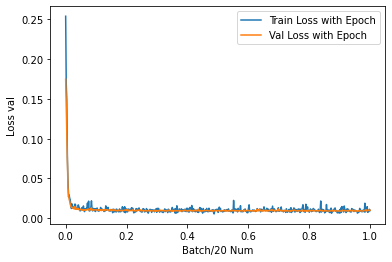

In [186]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

x = np.linspace( 0, 1, len(train_loss))
ax.plot(x, train_loss, label='Train Loss with Epoch')
ax.plot(x, validation_loss ,label='Val Loss with Epoch')
ax.set_xlabel('Batch/20 Num')
ax.set_ylabel('Loss val')
ax.legend()
plt.show()

# Load Model


In [111]:
encoder = model_utils.load_model(save_dir, 'encoder_newinput01')
decoder = model_utils.load_model(save_dir, 'encoder_newinput01')

In [187]:
data_test = pd.read_csv(processed_data_path + processed_data_files[-1])
input_seqsize = 20
rollout_len_test = 890

window_size_test = input_seqsize + rollout_len_test
data_temp = getConsecutive(data_test, window_size_test, DATA_STRIDE, FEATURE_SIZE)
model_input, state = getTestInput(data_temp, window_size_test, constant_)
test_dataset = TestDataset(model_input, state, None, input_seqsize, rollout_len_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
test_utils = ModelUtils(save_dir, 1, lstm_hidden_size, gpu_bool=gpu_bool)
# window len, number of data, data feature dim
print(model_input.shape) # 
print("0--3 is model input, 4,5 is acc, yaw rate respectively")

Add  (911, 5, 7)  data
(910, 6, 5)
0--3 is model input, 4,5 is acc, yaw rate respectively


RSME -- Acc      : 0.7234889277761879
RSME -- Yaw_rate : 15.24657622561644
RSME -- Speed    : 11.588710001415658
RSME -- Yaw      : 186.0538030591876
RSME -- Position : 211.083355370359
 


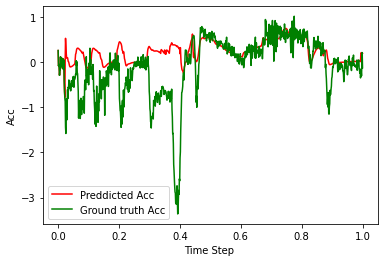

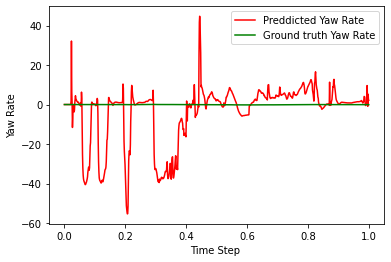

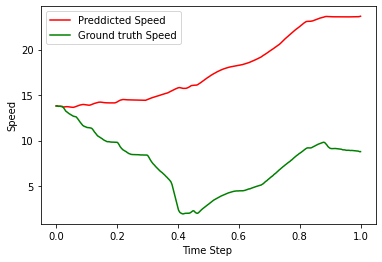

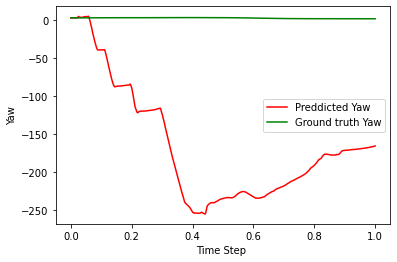

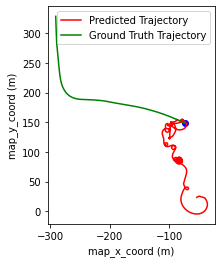

In [188]:
inputseq_len = input_seqsize
rollout_len = rollout_len_test

encoder.eval()
decoder.eval()

with torch.no_grad(): 
  for batch_index, data in enumerate(test_dataloader):

      predicted_acc = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw_rate = np.zeros(inputseq_len + rollout_len_test)

      predicted_speed = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw = np.zeros(inputseq_len + rollout_len_test)

      predicted_x = np.zeros(inputseq_len + rollout_len_test)
      predicted_y = np.zeros(inputseq_len + rollout_len_test)

      
      model_input, target, cumulated_state, command = data
      dT = cumulated_state[0, :, -1]
      # print(cumulated_state.shape)
      
      if gpu_bool:
              device = torch.device("cuda")
      else:
          device = torch.device("cpu")

      model_input = model_input.float().to(device)
      target = target.float().to(device)
      cumulated_state = cumulated_state.float().to(device)
      command = command.float().to(device)


      predicted_acc[:inputseq_len] = target[0, :inputseq_len, 0].cpu()
      predicted_yaw_rate[:inputseq_len] = target[0, :inputseq_len, 1].cpu()/constant_
      predicted_speed[:inputseq_len] = cumulated_state[0, :inputseq_len, -3].cpu()
      predicted_yaw[:inputseq_len] = cumulated_state[0, :inputseq_len, -2].cpu()
      predicted_x[:inputseq_len] = cumulated_state[0, :inputseq_len, 0].cpu()
      predicted_y[:inputseq_len] = cumulated_state[0, :inputseq_len, 1].cpu()

      for di in range(rollout_len):   
        # Initialize loss

        # Initialize encoder hidden state
        encoder_hidden = test_utils.init_zero_state()

        # print(model_input.shape)

        for ei in range(inputseq_len):
            encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_input = model_input[:, input_seqlen - 1, :]
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

        new_in = torch.cat((command[:, di + inputseq_len, :], decoder_output), 1)
        new_in = new_in[None, :, :]
        # print(decoder_output.shape)
        # print(new_in.shape)
        model_input = torch.cat((model_input[:, 1:, :], new_in), 1)

        predicted_acc[inputseq_len + di] = decoder_output[0, 0]
        predicted_yaw_rate[inputseq_len + di] = decoder_output[0, 1]/constant_

        # predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  target[0, inputseq_len + di - 1, 0].cpu()*dT[inputseq_len + di - 1]
        # predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +   target[0, inputseq_len + di - 1, 1].cpu()/constant_*dT[inputseq_len + di - 1]

        predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  predicted_acc[inputseq_len + di - 1]*dT[inputseq_len + di - 1]
        predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +  predicted_yaw_rate[inputseq_len + di - 1]*dT[inputseq_len + di - 1]

        predicted_x[inputseq_len + di] = predicted_x[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.cos(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        predicted_y[inputseq_len + di] = predicted_y[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.sin(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        

      acc_pred = torch.from_numpy(predicted_acc[inputseq_len:])
      yaw_rate_pred = torch.from_numpy(predicted_yaw_rate[inputseq_len:])
      speed_pred = torch.from_numpy(predicted_speed[inputseq_len:])
      yaw_pred = torch.from_numpy(predicted_yaw[inputseq_len:])
      x_pred = torch.from_numpy(predicted_x[inputseq_len:])
      y_pred = torch.from_numpy(predicted_y[inputseq_len:])

      rsme_acc = torch.sqrt(criterion(target[:, inputseq_len:, 0].cpu(), acc_pred.unsqueeze(0)))
      rsme_yaw_rate = torch.sqrt(criterion(target[:, inputseq_len:, 1].cpu()/constant_, yaw_rate_pred.unsqueeze(0)))
      rsme_speed = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -3].cpu(), speed_pred.unsqueeze(0)))
      rsme_yaw = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -2].cpu(), yaw_pred.unsqueeze(0)))
      mse_x = criterion(cumulated_state[:, inputseq_len:, 0].cpu(), x_pred.unsqueeze(0))
      mse_y = criterion(cumulated_state[:, inputseq_len:, 1].cpu(), y_pred.unsqueeze(0))
      rsme_position = torch.sqrt(mse_x + mse_y)

      print(f"RSME -- Acc      : {rsme_acc}")
      print(f"RSME -- Yaw_rate : {rsme_yaw_rate}")
      print(f"RSME -- Speed    : {rsme_speed}")
      print(f"RSME -- Yaw      : {rsme_yaw}")
      print(f"RSME -- Position : {rsme_position}")
      print(' ')  

      visualize_result_state(predicted_acc, target[0, :, 0].cpu(), "Acc")
      visualize_result_state(predicted_yaw_rate, target[0, :, 1].cpu()/constant_, "Yaw Rate")
      visualize_result_state(predicted_speed, cumulated_state[0, :, 2].cpu(), "Speed")
      visualize_result_state(predicted_yaw, cumulated_state[0, :, 3].cpu(), "Yaw")
      visualize_result_position(predicted_x, predicted_y, cumulated_state[0, :, 0].cpu(), cumulated_state[0, :, 1].cpu())

      break

In [ ]:
def test(test_dataLoader,
         encoder,
         decoder,
         model_utils,
         criterion,
         inputseq_len,
         rollout_len,):
  
  encoder.eval()
  decoder.eval()



  with torch.no_grad(): 
    for batch_idx, data in enumerate(test_dataLoader):

      predcited_acc = []
      predcited_yaw_rate = []
      predicted_speed = []
      predcited_yaw = []
      predicted_x = []
      predicted_y = []
      
      model_input, target, cumulated_state = data
      if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")

      model_input = model_input.float().to(device)

      target = target.float().to(device)
      cumulated_state = cumulated_state.float().to(device)


      original_input = model_input
      # Initialize loss
      loss = 0.0

      # Initialize encoder hidden state
      encoder_hidden = model_utils.init_zero_state()

      for ei in range(inputseq_len):
          encoder_hidden = encoder(original_input[:, ei, :], encoder_hidden)

      # Initialize decoder hidden state as encoder hidden state
      decoder_hidden = encoder_hidden

      decoder_input = model_input[:, input_seqlen - 1, :]
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

      predcited_state_list.append(decoder_output)

      # evaluation metric is RSME in 60 s prediction

  



2